# Package loading and basic configurations

In [6]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig


# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 10 tracks. The result is a GeoDataFrame, which is a geo-extended Pandas dataframe from the GeoPandas library. It contains all information of the track in a flat dataframe format including a specific geometry column. 

In [104]:
bbox = BboxSelector([
    7.601165771484375, # min_x
    51.94807412325402, # min_y
    7.648200988769531, # max_x
    51.97261482608728  # max_y
])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=50) # requesting 10 tracks inside the bbox
track_df

,id,time,geometry,Throttle Position.value,Throttle Position.unit,CO2.value,CO2.unit,GPS VDOP.value,GPS VDOP.unit,GPS Bearing.value,...,sensor.constructionYear,sensor.manufacturer,track.appVersion,track.touVersion,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,MAF.value,MAF.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5eb7582165b80c5d6be69f24,2020-05-09T21:10:46,POINT (7.65180 51.95396),16.000000,%,6.060965,kg/h,1.000000,precision,244.006986,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5eb7582165b80c5d6be69f26,2020-05-09T21:10:51,POINT (7.65169 51.95395),16.831018,%,7.644530,kg/h,1.000000,precision,273.231882,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5eb7582165b80c5d6be69f27,2020-05-09T21:10:56,POINT (7.65148 51.95395),16.846021,%,6.152178,kg/h,1.000000,precision,273.377388,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5eb7582165b80c5d6be69f28,2020-05-09T21:11:01,POINT (7.65127 51.95397),17.000001,%,7.380207,kg/h,0.930191,precision,274.705621,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5eb7582165b80c5d6be69f29,2020-05-09T21:11:06,POINT (7.65101 51.95396),15.151858,%,3.983817,kg/h,1.000000,precision,275.181028,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5dc985eb44ea856b702dd986,2019-10-29T16:10:53,POINT (7.59827 51.96493),16.027855,%,8.579484,kg/h,1.016152,precision,269.728716,...,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,5dc985eb44ea856b702dd987,2019-10-29T16:10:58,POINT (7.59737 51.96492),14.000000,%,4.308154,kg/h,1.015842,precision,268.303093,...,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,5dc985eb44ea856b702dd988,2019-10-29T16:11:03,POINT (7.59646 51.96492),32.000001,%,18.595897,kg/h,1.100000,precision,273.328479,...,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,5dc985eb44ea856b702dd989,2019-10-29T16:11:08,POINT (7.59541 51.96499),16.000000,%,7.105633,kg/h,1.267463,precision,276.193063,...,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


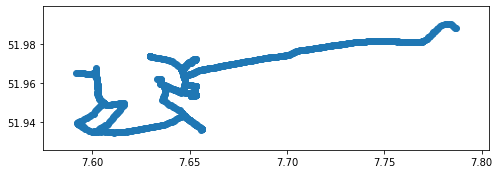

In [9]:
track_df.plot(figsize=(8, 10))

# Inspecting a single Track

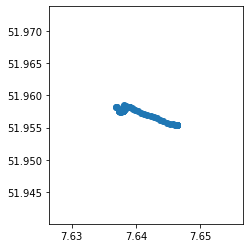

In [10]:
some_track_id = track_df['track.id'].unique()[5]
some_track = track_df[track_df['track.id'] == some_track_id]
some_track.plot()

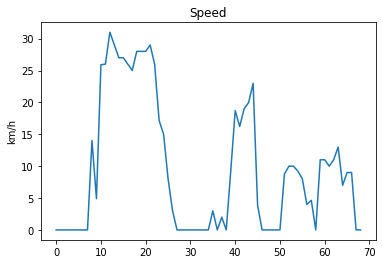

In [11]:
ax = some_track['Speed.value'].plot()
ax.set_title("Speed")
ax.set_ylabel(some_track['Speed.unit'][0])
ax

## Interactive Map
The following map-based visualization makes use of folium. It allows to visualizate geospatial data based on an interactive leaflet map. Since the data in the GeoDataframe is modelled as a set of Point instead of a LineString, we have to manually create a polyline

In [12]:
import folium

lats = list(some_track['geometry'].apply(lambda coord: coord.y))
lngs = list(some_track['geometry'].apply(lambda coord: coord.x))

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)

m = folium.Map(location=[avg_lat, avg_lngs], zoom_start=13)
folium.PolyLine([coords for coords in zip(lats, lngs)], color='blue').add_to(m)
m

# Format Converter

In [235]:
class TrackConverter():
    
    """Handles the envirocar Tracks"""
    
    def __init__(self,track):
        self.track = track
        self.crs = track.crs
        
    """ Returns a geoDataFrame object with the movingpandas plain format"""
    
    def to_movingpandas(self):
        
        gdf = self.track.copy()
        gdf = gdf.reindex(columns=(['geometry'] + list([a for a in sorted(gdf.columns) if a != 'geometry'])),copy=True)
        gdf['time']= gdf['time'].astype('datetime64[ns]')
        gdf.set_index('time',inplace=True)
        gdf.index.rename('t',inplace=True)
        return (gdf)
    
    """ Returns a dataFrame object with the scikitmobility plain format"""
    
    def to_scikitmobility(self):
        gdf = self.track.copy()
        gdf['lat'] = gdf.geometry.x
        gdf['lng'] = gdf.geometry.y
        gdf.rename(columns = ({"time": "datetime",'sensor.id':'uid','track.id':'tid'}),inplace=True)
        gdf['datetime'] = gdf['datetime'].astype('datetime64[ns]')
        gdf['tid'] = gdf['tid'].astype(str)
        gdf['uid'] = gdf['uid'].astype(str)
        columns=['uid','tid','lat','lng','datetime']
        gdf = gdf.reindex(columns = (columns + list([a for a in sorted(gdf.columns) if a not in columns])),copy = True)
        df = pd.DataFrame(gdf)
        return(df)
    